## IMPORT REQUIRED LIBRARIES

In [1]:
!pip install google-play-scraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import pandas as pd
import numpy as np
import tensorflow as tf
from google_play_scraper import Sort, reviews_all
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import time

## DATA COLLECTION

In [3]:
scrapreview = reviews_all(
    'com.bca',
    lang='id',
    sort=Sort.MOST_RELEVANT,
    filter_score_with=None
)

In [4]:
review_results_df = pd.DataFrame(scrapreview)
review_results_df.sample(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
117401,58efa05a-ab0f-468a-bbc6-30000e40e873,Murjan Nikmah,https://play-lh.googleusercontent.com/a/AEdFTp...,alhmdllah sangat membantu,5,0,2.9.0,2022-04-01 12:52:30,None,NaT
194134,8f659dbc-b9ac-4d3b-9ae9-f1eedb80a845,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ramah tamah,5,0,2.2.4,2020-01-26 05:39:19,Terima kasih atas ulasannya. Semoga fasilitas ...,2020-01-31 14:37:49
126530,2582e5e5-70c2-4717-99ac-f95a008c5104,rudi salam,https://play-lh.googleusercontent.com/a/AEdFTp...,Baru mau di coba,4,0,2.3.1,2020-05-14 10:25:39,Terima kasih atas ulasannya. Semoga fasilitas ...,2020-06-04 06:06:59
63945,f28b8652-7866-4eb5-a4db-e2c8a6fbf601,Arif Rifai,https://play-lh.googleusercontent.com/a-/AD5-W...,apakah harus selalu update ..?!. Klu ada updat...,3,0,2.5.2,2020-05-28 06:16:20,None,NaT
11942,abbbb8e2-616f-4fb4-818d-5ab7bbed8ad1,rata lebak bunter,https://play-lh.googleusercontent.com/a-/AD5-W...,Cuma saran kalo bisa setiap ada pengiriman/tra...,5,0,2.9.4,2022-07-02 04:36:21,"Dengan senang hati kami informasikan, jika men...",2022-07-02 05:12:48


In [5]:
review_results_df.to_csv('/BCA_mobile_review_results_(most_relevant).csv', index=None, header=True)

In [ ]:
review_results_df = pd.DataFrame(scrapreview)

## EXPLORATORY DATA ANALYSIS

In [6]:
review_results_df.shape

(197408, 10)

In [7]:
review_results_df.isnull().sum()

reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion    24910
at                          0
replyContent            13608
repliedAt               13608
dtype: int64

In [8]:
clean_df = review_results_df.drop(columns=['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt'])
clean_df.sample(5)

,content,score
65482,Kenpa saya gk bisa masuk d pake smalm bisa ska...,5
153331,Bagus,5
45759,Dgn adanya aplikasi bca mobile ini sy merasa s...,5
42962,Aplikasi mudah dioperasikan sangat membantu,5
74949,Sangat membantu sekali Transfer lebih muda,5


In [27]:
clean_df.score.value_counts()

5    131032
1     32682
4     13951
3     10724
2      9019
Name: score, dtype: int64

In [9]:
clean_df = clean_df.astype(str)

In [10]:
category = pd.get_dummies(clean_df.score)
final_df = pd.concat([clean_df, category], axis=1)
final_df = final_df.drop(columns='score')
final_df.sample(5)

,content,1,2,3,4,5
156190,Mantab,0,0,0,0,1
181218,Sangat bagus,0,0,0,0,1
137654,Nyaman,0,0,0,0,1
48814,sering eror padahal jaringan bagus...mohon d p...,0,0,1,0,0
104169,sangat membantu,0,0,0,0,1


## DATA PREPROCESSING

In [11]:
final_df.rename(
    columns=({'1':'very_bad','2':'bad','3':'average','4':'good','5':'very_good'}),
    inplace=True,
)
final_df.sample(5)

,content,very_bad,bad,average,good,very_good
0,"Semua data sudah benar, udah foto sendiri. Wah...",1,0,0,0,0
1,Buat halaman dong yg menampilkan nomor rekenin...,0,0,1,0,0
2,Teknologi scan isi data KTP otomatis sudah ses...,1,0,0,0,0
3,"Masak di upgrade versi baru barcode ngak ada ,...",0,1,0,0,0
4,"Kurang suka sama UI nya, kuno dan ribet bgt be...",0,1,0,0,0
...,...,...,...,...,...,...
197403,Membantu,0,0,0,1,0
197404,Simple,0,0,0,0,1
197405,Mantap,0,0,0,0,1
197406,Mantab,0,0,0,0,1


In [12]:
features = final_df['content'].values
categories = final_df[['very_bad','bad','average','good','very_good']]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features, categories, test_size=0.2)

In [50]:
MAX_FEATURES = 20000
OOV_TOKEN = 'x'

tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(train_seq, maxlen=8, padding="post",truncating="post")
X_test = pad_sequences(test_seq, maxlen=8, padding="post",truncating="post")

In [51]:
#X_train.shape, X_test.shape

((157926, 8), (39482, 8))

In [16]:
#X_test = np.lib.pad(X_train, ((0,0),(X_train.shape[1] - X_test.shape[1],0)), 'constant', constant_values=(0))

In [18]:
#X_train = np.lib.pad(X_train, ((0,0),(X_test.shape[1] - X_train.shape[1],0)), 'constant', constant_values=(0))

In [ ]:
#X_train.shape, X_test.shape

## MODEL SELECTION

In [52]:
INPUT_DIM = 20000
OUTPUT_DIM = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM),
    tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          1280000   
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1,317,509
Trainable params: 1,317,509
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

MODEL TRAINING

In [54]:
NUM_EPOCHS = 20

start = time.time()
history = model.fit(X_train, y_train,
                    epochs=NUM_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=2)
stop = time.time()
print(f'{stop-start}')

Epoch 1/20
4936/4936 - 218s - loss: 0.7135 - accuracy: 0.7692 - val_loss: 0.6810 - val_accuracy: 0.7805 - 218s/epoch - 44ms/step
Epoch 2/20
4936/4936 - 210s - loss: 0.6731 - accuracy: 0.7792 - val_loss: 0.6685 - val_accuracy: 0.7808 - 210s/epoch - 43ms/step
Epoch 3/20
4936/4936 - 223s - loss: 0.6583 - accuracy: 0.7827 - val_loss: 0.6772 - val_accuracy: 0.7814 - 223s/epoch - 45ms/step
Epoch 4/20
4936/4936 - 228s - loss: 0.6451 - accuracy: 0.7869 - val_loss: 0.6750 - val_accuracy: 0.7825 - 228s/epoch - 46ms/step
Epoch 5/20
4936/4936 - 217s - loss: 0.6335 - accuracy: 0.7900 - val_loss: 0.6803 - val_accuracy: 0.7803 - 217s/epoch - 44ms/step
Epoch 6/20
4936/4936 - 193s - loss: 0.6228 - accuracy: 0.7933 - val_loss: 0.6816 - val_accuracy: 0.7822 - 193s/epoch - 39ms/step
Epoch 7/20
4936/4936 - 175s - loss: 0.6117 - accuracy: 0.7971 - val_loss: 0.6914 - val_accuracy: 0.7807 - 175s/epoch - 35ms/step
Epoch 8/20
4936/4936 - 174s - loss: 0.6011 - accuracy: 0.8011 - val_loss: 0.7053 - val_accuracy: 

<function matplotlib.pyplot.show(*args, **kw)>

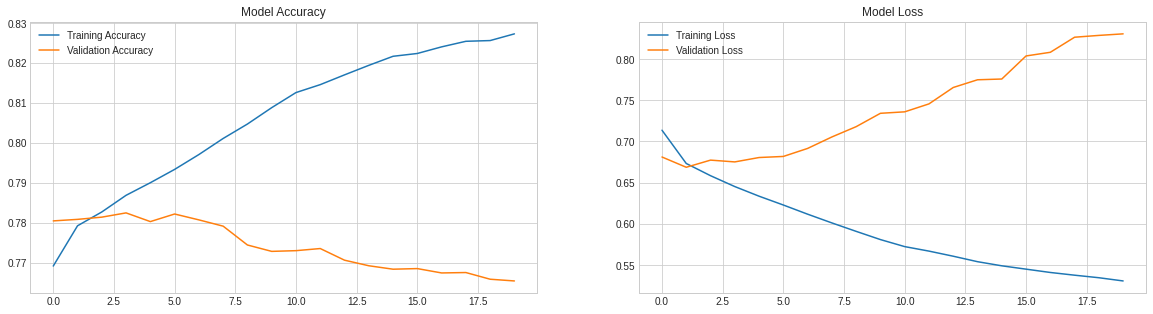

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.style.use('seaborn-whitegrid')
plt.subplots(1, 2, figsize=[20, 5])
plt.subplot(1,2,1)
acc = plt.plot(epochs, acc, label='Training Accuracy')
val_acc = plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend(loc=0)
plt.subplot(1,2,2)
acc = plt.plot(epochs, loss, label='Training Loss')
val_acc = plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.legend(loc=0)
plt.savefig('training_performance')
plt.show

Save the model

In [61]:
model.save('app_review_sentiment_analysis.h5')

## PREDICTION

In [69]:
def sentiment_prediction(sentence, model=model):
  sequence = tokenizer.texts_to_sequences([sentence])
  test = pad_sequences(sequence, maxlen=8, padding="post",truncating="post")
  predict_array = model.predict(test[0])

  probability_df = pd.DataFrame(predict_array)
  probability_df = probability_df.rename({0:'Probability'}, axis = 'columns')
  sentiments = ['very bad', 'bad', 'average', 'good', 'very good']
  probability_df['sentiment'] = sentiments
  
  prediction_category = np.argmax(model.predict(test), axis=1)[0]
  
  if prediction_category == 0:
    prediction_result = 'very bad'
  elif prediction_category == 1:
    prediction_result = 'bad'
  elif prediction_category == 2:
    prediction_result = 'average'
  elif prediction_category == 3:
    prediction_result = 'good'
  else:
    prediction_result = 'very good'

  return prediction_result, probability_df

In [ ]:
sentence = "Aplikasinya bagus"
prediction_result, probability_df = sentiment_prediction(sentence)

print('\nThis comment was detected as ' + prediction_result +  ' sentiment')

probability_df.sort_values(by='Probability', ascending=False)